In [15]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from collections import defaultdict

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.special import softmax as softmax
import matplotlib.pyplot as plt

from dataloader.builder import build_dataset
from experiment_setup import build_estimator
from uncertainty_estimator.masks import build_masks, DEFAULT_MASKS
from analysis.metrics import uq_ndcg

from model.cnn import SimpleConv, MediumConv, StrongConv
from model.trainer import Trainer, EnsembleTrainer
from active_learning.al_trainer import ALTrainer
from active_learning.sample_selector import EagerSampleSelector, StochasticSampleSelector

# torch.cuda.set_device(1)

In [17]:

config = {
    'use_cuda': True,
    'seed': 1,
    
    'nn_runs': 100,
    'patience': 5,
    'dropout_uq': 0.5,
    
    'n_models': 10, 
    
    'dataset': 'mnist',
    # 'dataset': 'cifar_10',
    
    'model_runs': 3,   
    
    'al_iterations': 20,
    'sampler_type': 'eager'
    # 'sampler_type': 'stochastic'
}


model_setups = {
    'mnist': {
        'model_class': SimpleConv,
        'epochs': 5,
        'batch_size': 32,
        'log_interval': 10,
        'lr': 1e-2,
        'num_classes': 10,
        'input_shape': (-1, 1, 28, 28),
        'al_start': 300,
        'al_step': 200,
        'pool_size': 10_000
    },
    'cifar_10': {
        'model_class': MediumConv,
        'epochs': 50,
        'batch_size': 256,
        'log_interval': 150,
        'lr': 1e-2,
        'num_classes': 10,
        'input_shape': (-1, 3, 32, 32),
        'al_start': 10_000,
        'al_step': 1000,
        'pool_size': 25_000
    }
}

config.update(model_setups[config['dataset']])



#### Load data and preprocess

In [18]:
dataset = build_dataset(config['dataset'], val_size=10_000)
x_set, y_set = dataset.dataset('train')
x_val, y_val = dataset.dataset('val')



In [19]:
def scale(images):
    return (images - 128) / 128
x_set = scale(x_set)
x_val = scale(x_val)

In [20]:
x_set = x_set.reshape(config['input_shape'])
x_val = x_val.reshape(config['input_shape'])

y_set = y_set.astype('long').reshape(-1)
y_val = y_val.astype('long').reshape(-1)



#### Train model

In [21]:
def al_evaluate(
        model, estimator, x_train, y_train, x_val, y_val, x_pool):
    """Train """
    sampler = EagerSampleSelector()
        
    active_teacher = ALTrainer(
        model, estimator, patience=3, update_size=200, y_pool=y_pool,
        iterations=config['al_iterations'], verbose=False, sampler=sampler,
        val_on_pool=True)
    errors = active_teacher.train(
        x_train.copy(), y_train.copy(), x_val.copy(), y_val.copy(), x_pool.copy())
    return errors

In [22]:
ranks = []
errors = []

for i in range(config['model_runs']):
    print("\n", i, "\n")
    
    mask = build_masks(['rank_dpp'])['rank_dpp']
    
    x_train, x_pool, y_train, y_pool= train_test_split(
        x_set, y_set, train_size=config['al_start'], stratify=y_set)
    x_pool, _, y_pool, _ = train_test_split(x_pool, y_pool, train_size=config['pool_size'])
    masks = build_masks(DEFAULT_MASKS)

    model = config['model_class'](num_classes=config['num_classes'])
    trainer = Trainer(model, batch_size=config['batch_size'])
    estimator = build_estimator(
        'bald_masked', trainer, nn_runs=config['nn_runs'], dropout_mask=mask,
        dropout_rate=config['dropout_uq'], num_classes=config['num_classes'])
    
    model_errors = al_evaluate(trainer, estimator, x_train, y_train, x_val, y_val, x_pool)
    ranks.append(mask.ranks_history)
    errors.append(model_errors)


 0 

Iteration 1
Validation error after training: 0.568
Iteration 2
Validation error after training: 0.524
Iteration 3
Validation error after training: 0.418
Iteration 4
Validation error after training: 0.270
Iteration 5
Validation error after training: 0.177
Iteration 6
Validation error after training: 0.133
Iteration 7
Validation error after training: 0.124
Iteration 8
Validation error after training: 0.077
Iteration 9
Validation error after training: 0.056
Iteration 10
Validation error after training: 0.044
Iteration 11
Validation error after training: 0.028
Iteration 12
Validation error after training: 0.023
Iteration 13
Validation error after training: 0.017
Iteration 14
Validation error after training: 0.013
Iteration 15
Validation error after training: 0.009
Iteration 16
Validation error after training: 0.002
Iteration 17
Validation error after training: 0.004
Iteration 18
Validation error after training: 0.002
Iteration 19
Validation error after training: 0.002
Iteration 20
Va

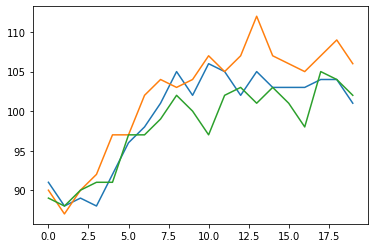

In [23]:
for rank_history in ranks:
    plt.plot(rank_history[1])

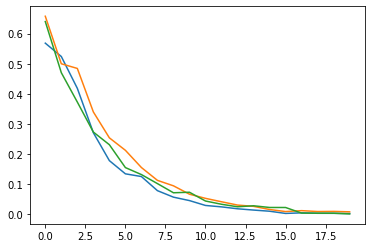

In [24]:
plt.figure()
for error_list in errors:
    plt.plot(error_list)